#### Cleaning Steps - Demographics Data and Airport Codes

  - Only Select States that are part of Facts Table


In [2]:
from datetime import datetime, timedelta
from numpy import nan
import numbers
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from immigration_lib.aws_tools import create_spark_session
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from os import getcwd

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

aws_config = f"{getcwd()}/aws_config.cfg"
spark = create_spark_session(aws_config, {}, "Cleaning Demographic and Airport Codes")

#### Airport Codes

In [5]:
airport_codes = './airport-codes.csv'
airport_codes_df = pd.read_csv(airport_codes)

In [6]:
us_airports_filtered_by_iso_country = airport_codes_df[(airport_codes_df['iso_country'] == "US") | (airport_codes_df['iso_country'] == "GU") | (airport_codes_df['iso_country'] == "PR") | (airport_codes_df['iso_country'] == "VI")]
unique_by_country = us_airports_filtered_by_iso_country['iso_region'].unique()
print(us_airports_filtered_by_iso_country.shape)

us_territories = [ "PR", "VI", "GU" ]
for territory in us_territories:
    print(us_airports_filtered_by_iso_country[us_airports_filtered_by_iso_country['iso_country'] == territory]["iso_region"].unique())

(22834, 12)
['PR-U-A']
['VI-U-A']
['GU-U-A']


- Puerto Rico, Virgin Islands, and Guam country codes obtained from here: https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
- Puerto Rico, Virgin Islands, and Guam have no state.
- We can observe that the coordinate comes in `Longitude, Latitude` as the first number goes above 90.
- We take a more traditional approach to finding the State using the `iso_region` and can use `municipality` to join with the city, acknowledging it might not always show up.

In [7]:
def get_state(iso_region):
    chunks = iso_region.split('-')
    possible_state = "-".join(chunks[1:])
    list_of_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    districts = ["DC"]
    if possible_state in list_of_states or possible_state in districts:
        return possible_state
    if iso_region.startswith("PR") or iso_region.startswith("GU") or iso_region.startswith("VI"):
        return chunks[0]
    return None

us_airports_filtered_by_iso_country['State'] = us_airports_filtered_by_iso_country['iso_region'].apply(get_state)
display(us_airports_filtered_by_iso_country.iloc[:5])

us_territories = [ "PR", "VI", "GU" ]
for territory in us_territories:
    print(us_airports_filtered_by_iso_country[us_airports_filtered_by_iso_country['iso_country'] == territory]["State"].unique())

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,State
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125",PA
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022",KS
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968",AK
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",AL
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087",AR


['PR']
['VI']
['GU']


In [10]:
len(us_airports_filtered_by_iso_country['coordinates'].unique())

22819

In [13]:
print(us_airports_filtered_by_iso_country[us_airports_filtered_by_iso_country['State'].isnull()]['iso_region'].unique())

us_airports_filtered_by_iso_country[us_airports_filtered_by_iso_country['iso_region'].str.endswith('VI')]

['US-U-A']


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,State


Simple check to see if we can use Int on Elevation

In [14]:
us_airports_filtered_by_iso_country['check'] = us_airports_filtered_by_iso_country['elevation_ft'].fillna(0).apply(lambda el: el.is_integer())

us_airports_filtered_by_iso_country[(us_airports_filtered_by_iso_country['check'] == False)]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,State,check


Unfortunately, we won't be pulling the coordinate data for 22,743 sets of coordinates as it would be too expensive in both time and cost.

#### Visualizing our Coordinates

Quickly visualizing all our coordinates will validate our assumptions about the airports. We can then proceed and use on the US airports to observe how an Airport might not be inside the 50 States.

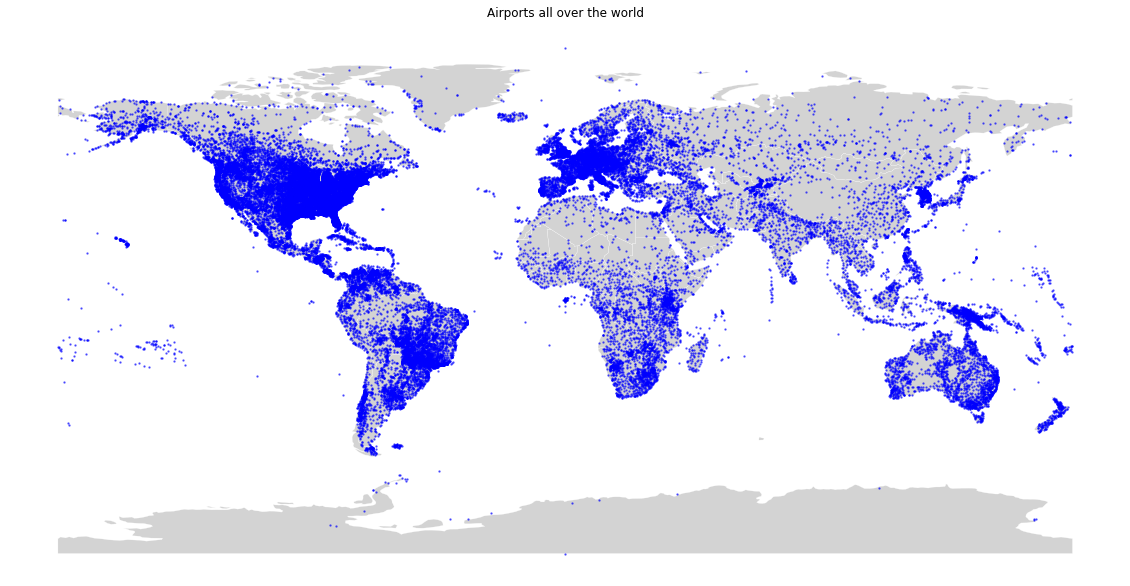

In [15]:
def latlong_string_to_Point(lat_long):
    latlong = list(map(float, lat_long.split(',')))
    return Point(latlong)

crs = { 'init': 'epsg:4326' }
geometry = [latlong_string_to_Point(xy) for xy in airport_codes_df['coordinates']]

geo_df = gpd.GeoDataFrame(airport_codes_df, crs = crs, geometry = geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(20,12), linewidth=0.25, edgecolor='white', color='lightgrey')
geo_df.plot(markersize=2, color='blue', alpha=0.5, ax=ax)
ax.axis('off')
plt.title("Airports all over the world")
plt.show()

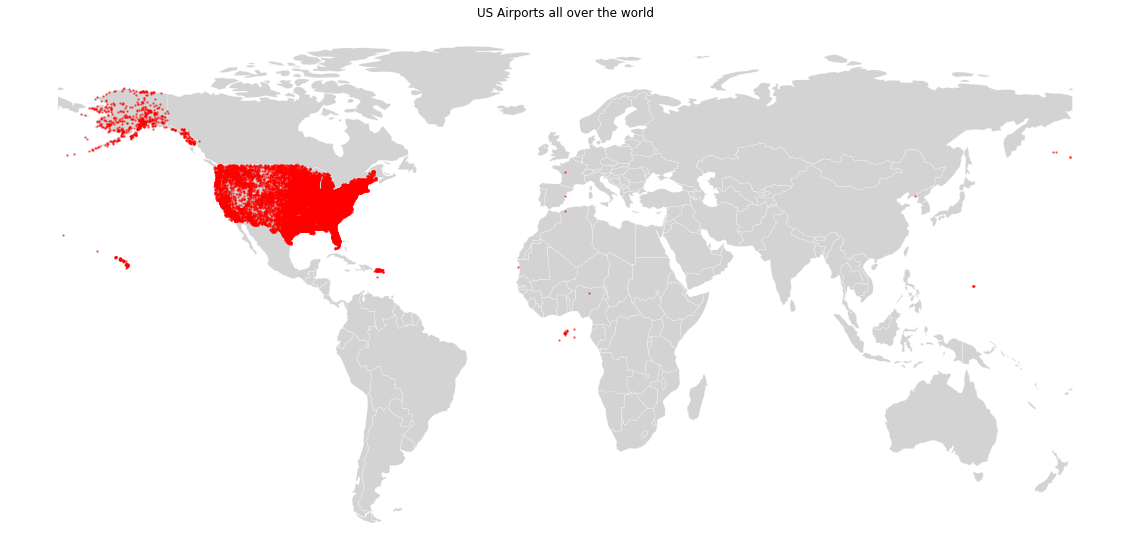

In [17]:
geometry = [latlong_string_to_Point(xy) for xy in us_airports_filtered_by_iso_country['coordinates']]

geo_df = gpd.GeoDataFrame(us_airports_filtered_by_iso_country, crs = crs, geometry = geometry)

world_no_antarctica = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

ax = world_no_antarctica.plot(figsize=(20,12), linewidth=0.25, edgecolor='white', color='lightgrey')
geo_df.plot(markersize=2, color='red', alpha=0.5, ax=ax)
ax.axis('off')
plt.title("US Airports all over the world")
plt.show()

In [18]:
# Final Processing 
from pyspark.sql.types import StringType, IntegerType

parse_state_udf = udf(get_state, StringType())
airport_codes = './airport-codes.csv'
airport_codes_spdf = spark.read\
                    .option("header",True) \
                    .option("nullValue", "null") \
                    .csv(airport_codes)

us_airport_codes_spdf = airport_codes_spdf.filter(col('iso_country') == "US") \
                        .withColumn("state", parse_state_udf(col('iso_region'))) \
                        .withColumn("elevation", col("elevation_ft").cast(IntegerType())) \
                        .drop("continent", "elevation_ft")
us_airport_codes_spdf.printSchema()
print(us_airport_codes_spdf.count())
display(us_airport_codes_spdf.limit(1).toPandas())
# To write to S3
output_data = "s3a://claudiordgz-udacity-dend"
us_airport_codes_spdf.write.parquet(f'{output_data}/capstone/staging_airport_codes', mode='append')

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- state: string (nullable = true)
 |-- elevation: integer (nullable = true)

22757


,ident,type,name,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,state,elevation
0,00A,heliport,Total Rf Heliport,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125",PA,11


In [19]:
demographic_data = './us-cities-demographics.csv'
ddf = pd.read_csv(demographic_data, sep=';')
ddf.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [26]:
from pyspark.sql.types import DoubleType

integer_columns = [
'malePopulation',
'femalePopulation',
'totalPopulation',
'numberOfVeterans',
'foreignBorn',
'count'
]
demographic_data_df = spark.read\
                    .option("header",True) \
                    .option("nullValue", "null") \
                    .option("delimiter", ";") \
                    .csv(demographic_data) \
                    .withColumn("Average Household Size", col("Average Household Size").cast(DoubleType())) \
                    .withColumn("Median Age", col("Median Age").cast(DoubleType())) \
                    .withColumnRenamed("City", "city") \
                    .withColumnRenamed("State", "state") \
                    .withColumnRenamed("Median Age", "medianAge") \
                    .withColumnRenamed("Male Population", "malePopulation") \
                    .withColumnRenamed("Female Population", "femalePopulation") \
                    .withColumnRenamed("Total Population", "totalPopulation") \
                    .withColumnRenamed("Number of Veterans", "numberOfVeterans") \
                    .withColumnRenamed("Foreign-born", "foreignBorn") \
                    .withColumnRenamed("Average Household Size", "averageHouseholdSize") \
                    .withColumnRenamed("State Code", "stateCode") \
                    .withColumnRenamed("Race", "race") \
                    .withColumnRenamed("Count", "count")

for integer_col in integer_columns:
    demographic_data_df = demographic_data_df.withColumn(integer_col, col(integer_col).cast(IntegerType()))


demographic_data_df.printSchema()


display(demographic_data_df.limit(2).toPandas())

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- medianAge: double (nullable = true)
 |-- malePopulation: integer (nullable = true)
 |-- femalePopulation: integer (nullable = true)
 |-- totalPopulation: integer (nullable = true)
 |-- numberOfVeterans: integer (nullable = true)
 |-- foreignBorn: integer (nullable = true)
 |-- averageHouseholdSize: double (nullable = true)
 |-- stateCode: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: integer (nullable = true)



,city,state,medianAge,malePopulation,femalePopulation,totalPopulation,numberOfVeterans,foreignBorn,averageHouseholdSize,stateCode,race,count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723


In [27]:
demographic_data_df.write.parquet(f'{output_data}/capstone/staging_demographic_data', mode='append')